# Decision Making in NBA Clutch Time

This notebook presents an end-to-end analysis of NBA clutch-time events,
including exploratory data analysis, hypothesis testing, and a machine
learning–based decision support model.

The objective is to evaluate which in-game actions are most strongly
associated with score changes under high-pressure situations.


## Analysis Workflow

1. **Data Loading and Preprocessing**  
   Load and clean NBA play-by-play data and construct relevant features.

2. **Exploratory Data Analysis (EDA)**  
   Examine action distributions and time-based patterns in clutch time.

3. **Hypothesis Testing**  
   Test whether action types depend on remaining time using a chi-square test.

4. **Possession-Level Target Construction**  
   Define a win-proxy target indicating whether a possession results in a score change.

5. **Modeling**  
   Train a logistic regression model to estimate score-change probabilities.

6. **Scenario-Based Decision Support**  
   Demonstrate how the model can support late-game decision making.


In [1]:
print("Hello DSA210")


Hello DSA210


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import sklearn
import scipy
import statsmodels

print("OK ✅", np.__version__, pd.__version__)


OK ✅ 1.24.3 2.0.3


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Notebook görünüm ayarları
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

print("Setup OK ✅")


Setup OK ✅


# NBA Last 3 Minutes (Clutch Time) Strategy Optimization

**Course:** DSA210 – Introduction to Data Science (Fall 2025–2026)  
**Student:** Yusuf Berk Şahin  

## Motivation
In close NBA games, decisions in the final minutes can strongly affect the outcome.  
This project analyzes play-by-play and contextual factors in the last 3 minutes to understand what patterns are associated with winning/losing in clutch situations.

## Project Questions (initial)
- Which actions/events (e.g., turnovers, fouls, shot selection) are most associated with winning in the last 3 minutes?
- Do home/away, score margin, or time remaining change these patterns?
- Can we build a model that predicts win probability (or success) using last-3-minute features?


In [4]:
# Load processed clutch-time data
data_path = "../data/processed/processed_critical_moments.csv"

df = pd.read_csv(data_path)

print("Data loaded successfully ✅")
print("Shape:", df.shape)


Data loaded successfully ✅
Shape: (4772, 61)


In [5]:
# Preview the data
df.head()


,actionNumber,clock,timeActual,period,periodType,actionType,subType,qualifiers,personId,x,y,possession,scoreHome,scoreAway,edited,orderNumber,xLegacy,yLegacy,isFieldGoal,side,description,personIdsFilter,teamId,teamTricode,descriptor,jumpBallRecoveredName,jumpBallRecoverdPersonId,playerName,playerNameI,jumpBallWonPlayerName,jumpBallWonPersonId,jumpBallLostPlayerName,jumpBallLostPersonId,shotDistance,shotResult,pointsTotal,assistPlayerNameInitial,assistPersonId,assistTotal,shotActionNumber,reboundTotal,reboundDefensiveTotal,reboundOffensiveTotal,officialId,foulPersonalTotal,foulTechnicalTotal,foulDrawnPlayerName,foulDrawnPersonId,turnoverTotal,stealPlayerName,stealPersonId,blockPlayerName,blockPersonId,GAME_ID,time_remaining,score_diff,GAME_DATE,MATCHUP,value,time_bin,score_bucket
0,630,PT02M53.00S,2021-05-17T01:05:36.8Z,4,REGULAR,stoppage,blood rule,[],0,NaN,NaN,1610612737,115,92,2021-05-17T01:05:36Z,6230000,NaN,NaN,0,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22001066,173,0,2021-05-16,ATL vs. HOU,NaN,151-180s,Home -1 to -3
1,631,PT02M43.00S,2021-05-17T01:06:44.3Z,4,REGULAR,3pt,Jump Shot,[],203524,31.488173,75.559130,1610612737,115,92,2021-05-17T01:06:49Z,6240000,-128.0,243.0,1,left,MISS S. Hill 27' 3PT,[203524],1.610613e+09,ATL,NaN,NaN,NaN,Hill,S. Hill,NaN,NaN,NaN,NaN,27.50,Missed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22001066,163,0,2021-05-16,ATL vs. HOU,NaN,151-180s,Home -1 to -3
2,632,PT02M38.00S,2021-05-17T01:06:49.3Z,4,REGULAR,rebound,defensive,[],1629717,NaN,NaN,1610612745,115,92,2021-05-17T01:06:49Z,6250000,NaN,NaN,0,NaN,A. Brooks REBOUND (Off:0 Def:4),[1629717],1.610613e+09,HOU,NaN,NaN,NaN,Brooks,A. Brooks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,631.0,4.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22001066,158,0,2021-05-16,ATL vs. HOU,NaN,151-180s,Home -1 to -3
3,633,PT02M29.00S,2021-05-17T01:06:57.1Z,4,REGULAR,3pt,Jump Shot,[],1629717,68.413272,45.412071,1610612745,115,92,2021-05-17T01:07:02Z,6260000,-23.0,244.0,1,right,MISS A. Brooks 24' pullup 3PT,[1629717],1.610613e+09,HOU,pullup,NaN,NaN,Brooks,A. Brooks,NaN,NaN,NaN,NaN,24.55,Missed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22001066,149,0,2021-05-16,ATL vs. HOU,NaN,121-150s,Home -1 to -3
4,634,PT02M25.00S,2021-05-17T01:07:01.1Z,4,REGULAR,rebound,defensive,[],1630233,NaN,NaN,1610612737,115,92,2021-05-17T01:07:02Z,6270000,NaN,NaN,0,NaN,N. Knight REBOUND (Off:1 Def:6),[1630233],1.610613e+09,ATL,NaN,NaN,NaN,Knight,N. Knight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,633.0,7.0,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22001066,145,0,2021-05-16,ATL vs. HOU,NaN,121-150s,Home -1 to -3


In [6]:
# Data structure and missing values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4772 entries, 0 to 4771
Data columns (total 61 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   actionNumber              4772 non-null   int64  
 1   clock                     4772 non-null   object 
 2   timeActual                4772 non-null   object 
 3   period                    4772 non-null   int64  
 4   periodType                4772 non-null   object 
 5   actionType                4772 non-null   object 
 6   subType                   4594 non-null   object 
 7   qualifiers                4772 non-null   object 
 8   personId                  4772 non-null   int64  
 9   x                         1244 non-null   float64
 10  y                         1244 non-null   float64
 11  possession                4772 non-null   int64  
 12  scoreHome                 4772 non-null   int64  
 13  scoreAway                 4772 non-null   int64  
 14  edited  

In [7]:
# Summary statistics
df.describe(include="all")


,actionNumber,clock,timeActual,period,periodType,actionType,subType,qualifiers,personId,x,y,possession,scoreHome,scoreAway,edited,orderNumber,xLegacy,yLegacy,isFieldGoal,side,description,personIdsFilter,teamId,teamTricode,descriptor,jumpBallRecoveredName,jumpBallRecoverdPersonId,playerName,playerNameI,jumpBallWonPlayerName,jumpBallWonPersonId,jumpBallLostPlayerName,jumpBallLostPersonId,shotDistance,shotResult,pointsTotal,assistPlayerNameInitial,assistPersonId,assistTotal,shotActionNumber,reboundTotal,reboundDefensiveTotal,reboundOffensiveTotal,officialId,foulPersonalTotal,foulTechnicalTotal,foulDrawnPlayerName,foulDrawnPersonId,turnoverTotal,stealPlayerName,stealPersonId,blockPlayerName,blockPersonId,GAME_ID,time_remaining,score_diff,GAME_DATE,MATCHUP,value,time_bin,score_bucket
count,4772.000000,4772,4772,4772.000000,4772,4772,4594,4772,4.772000e+03,1244.000000,1244.000000,4.772000e+03,4772.000000,4772.000000,4772,4.772000e+03,1244.000000,1244.000000,4772.000000,1244,4645,4772,4.437000e+03,4437,1075,18,1.400000e+01,4077,4077,18,1.800000e+01,18,1.800000e+01,1244.000000,1808,1021.000000,331,3.310000e+02,331.000000,795.000000,645.000000,645.000000,645.000000,5.260000e+02,379.000000,379.00000,374,3.740000e+02,174.000000,103,1.030000e+02,72,7.200000e+01,4.772000e+03,4772.000000,4772.0,4772,4772,28,4648,4772
unique,NaN,651,3779,NaN,2,18,42,36,NaN,NaN,NaN,NaN,NaN,NaN,3502,NaN,NaN,NaN,NaN,2,3293,1136,NaN,30,44,13,NaN,326,363,15,NaN,15,NaN,NaN,2,NaN,141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129,NaN,NaN,68,NaN,45,NaN,NaN,NaN,NaN,84,84,17,6,1
top,NaN,PT00M00.00S,2021-04-11T21:20:56.7Z,NaN,REGULAR,substitution,Jump Shot,[],NaN,NaN,NaN,NaN,NaN,NaN,2021-03-14T02:52:32Z,NaN,NaN,NaN,NaN,left,TEAM offensive REBOUND,[],NaN,ATL,driving,Team (BOS),NaN,Young,T. Young,Poeltl,NaN,Capela,NaN,NaN,Made,NaN,T. Young,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Young,NaN,NaN,Waters,NaN,Fall,NaN,NaN,NaN,NaN,2021-04-01,ATL @ SAS,Out of Bounds - Overturn Call,0-30s,Home -1 to -3
freq,NaN,226,18,NaN,4347,866,800,3246,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN,631,112,689,NaN,1531,153,3,NaN,273,273,3,NaN,4,NaN,NaN,1021,NaN,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47,NaN,NaN,6,NaN,9,NaN,NaN,NaN,NaN,187,187,6,1486,4772
mean,643.890402,NaN,NaN,4.105197,NaN,NaN,NaN,NaN,9.746879e+05,49.370387,48.591908,1.573824e+09,109.926655,108.590738,NaN,6.314257e+06,-0.913183,104.086013,0.260687,NaN,NaN,NaN,1.610613e+09,NaN,NaN,NaN,1.119210e+06,NaN,NaN,NaN,1.391305e+06,NaN,1.074287e+06,14.833312,NaN,18.451518,NaN,1.248364e+06,5.021148,637.187421,6.114729,4.750388,1.364341,4.329585e+05,2.960422,0.05277,NaN,1.173076e+06,2.758621,NaN,1.213873e+06,NaN,1.151127e+06,2.200063e+07,75.574183,0.0,NaN,NaN,NaN,NaN,NaN
std,46.022899,NaN,NaN,0.355568,NaN,NaN,NaN,NaN,7.459318e+05,35.152637,22.917573,2.406479e+08,12.220022,12.679247,NaN,4.617917e+05,114.796075,104.476806,0.439056,NaN,NaN,NaN,9.530652e+00,NaN,NaN,NaN,7.092491e+05,NaN,NaN,NaN,5.465453e+05,NaN,7.146946e+05,11.367474,NaN,11.209977,NaN,6.336729e+05,3.624350,43.672889,4.399589,3.275358,1.837912,6.348382e+05,1.351470,0.22387,NaN,6.684523e+05,1.798943,NaN,6.510931e+05,NaN,6.812361e+05,3.071055e+02,61.860799,0.0,NaN,NaN,NaN,NaN,NaN
min,535.000000,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,0.000000e+00,4.418528,0.068934,0.000000e+00,74.000000,73.000000,NaN,5.250000e+06,-239.000000,-31.000000,0.000000,NaN,NaN,NaN,1.610613e+09,NaN,NaN,NaN,2.007520e+05,NaN,NaN,NaN,2.034570e+05,NaN,2.026840e+05,0.000000,NaN,1.000000,NaN,1.011080e+05,1.000000,535.000000,1.000000,0.000000,0.000000,1.146000e+03,1.000000,0.00000,NaN,2.544000e+03,1.000000,NaN,2.011450e+05,NaN,2.544000e+03,2.200002e+07,0.000000,0.0,NaN,NaN,NaN,NaN,NaN
25%,613.000000,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,2.026870e+05,11.350197,38.488051,1.610613e+09,101.000000,99.000000,NaN,6.000000e+06,-51.000000,14.000000,0.000000,NaN,NaN,NaN,1.610613e+09,NaN,NaN,NaN,2.039350e+05,NaN,NaN,NaN,1.627751e+06,NaN,2.039910e+05,2.622500,NaN,10.000000,NaN,2.039920e+05,2.000000,608.000000,3.000000,2.000000,0.000000,2.004000e+03,2

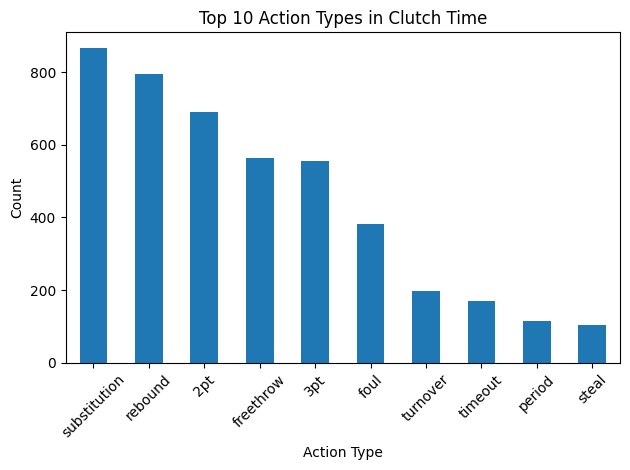

In [8]:
# Distribution of action types in clutch time
action_counts = df["actionType"].value_counts().head(10)

plt.figure()
action_counts.plot(kind="bar")
plt.title("Top 10 Action Types in Clutch Time")
plt.xlabel("Action Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Interpretation:**  
The distribution of action types during clutch time shows that substitutions and rebounds occur most frequently, indicating frequent tactical adjustments and possession battles in the final minutes. Shot attempts (2pt and 3pt) and free throws are also dominant, highlighting the importance of scoring efficiency under pressure. Although turnovers and timeouts occur less frequently, they represent high-impact events that can significantly influence game outcomes.


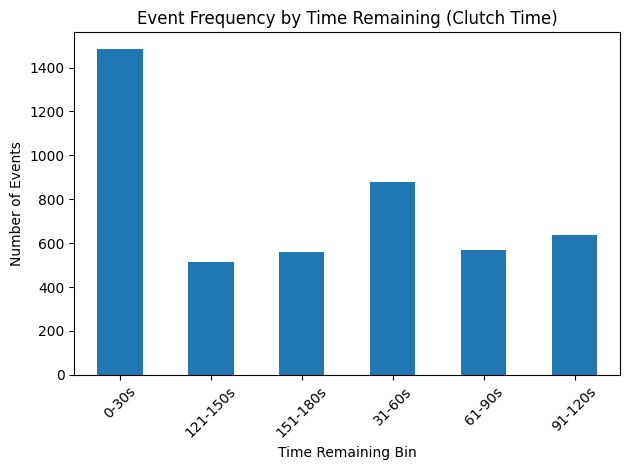

In [9]:
# Events by time remaining (time bins)
time_bin_counts = df["time_bin"].value_counts().sort_index()

plt.figure()
time_bin_counts.plot(kind="bar")
plt.title("Event Frequency by Time Remaining (Clutch Time)")
plt.xlabel("Time Remaining Bin")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Interpretation:**  
The time-bin analysis reveals a clear increase in event frequency as the game approaches its final seconds. The 0–30 second interval exhibits the highest concentration of events, supporting the definition of clutch time as a period of intensified strategic activity and high-pressure decision-making.


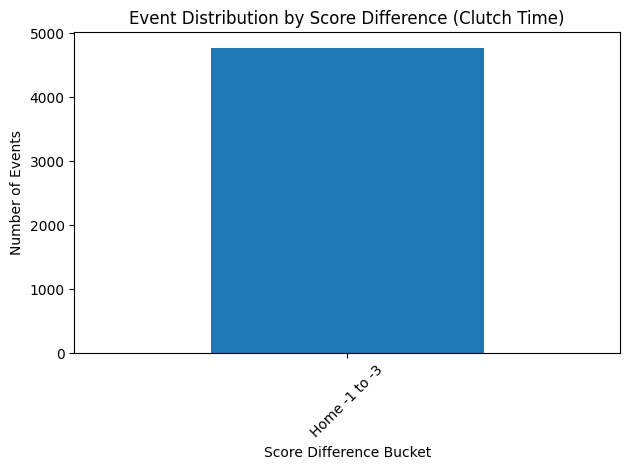

In [ ]:
# Events by score difference bucket
score_bucket_counts = df["score_bucket"].value_counts().sort_index()

plt.figure()
score_bucket_counts.plot(kind="bar")
plt.title("Event Distribution by Score Difference (Clutch Time)")
plt.xlabel("Score Difference Bucket")
plt.ylabel("Number of Events")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [12]:
# Create a new score difference category
def score_diff_category(diff):
    if abs(diff) <= 1:
        return "Very Close (±1)"
    elif abs(diff) <= 3:
        return "Close (±3)"
    else:
        return "Not Close (>3)"

df["score_diff_cat"] = df["score_diff"].apply(score_diff_category)

df["score_diff_cat"].value_counts()


score_diff_cat
Very Close (±1)    4772
Name: count, dtype: int64

In [13]:
# Simplify action types for statistical testing
important_actions = [
    "2pt", "3pt", "freethrow", "turnover", "foul", "rebound"
]

df["action_simple"] = df["actionType"].where(
    df["actionType"].isin(important_actions),
    other="other"
)

df["action_simple"].value_counts()


action_simple
other        1590
rebound       795
2pt           689
freethrow     564
3pt           555
foul          381
turnover      198
Name: count, dtype: int64

In [14]:
# Simplify time bins for statistical testing
important_time_bins = ["0-30s", "31-60s", "61-90s"]

df["time_bin_simple"] = df["time_bin"].where(
    df["time_bin"].isin(important_time_bins),
    other="other"
)

df["time_bin_simple"].value_counts()


time_bin_simple
other     1837
0-30s     1486
31-60s     880
61-90s     569
Name: count, dtype: int64

In [15]:
# Contingency table: Action Type vs Time Bin
contingency_table = pd.crosstab(
    df["action_simple"],
    df["time_bin_simple"]
)

contingency_table


time_bin_simple,0-30s,31-60s,61-90s,other
action_simple,,,,
2pt,113,129,109,338
3pt,116,88,89,262
foul,128,70,41,142
freethrow,222,105,53,184
other,681,323,145,441
rebound,188,128,107,372
turnover,38,37,25,98


In [16]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency_table)

chi2, p, dof


(316.96229659228084, 1.5458109221248776e-56, 18)

**Chi-Square Test Result:**  
A chi-square test of independence was conducted to examine the relationship between action types and time remaining during clutch time. The results indicate a statistically significant association between these variables (χ² = 316.96, p < 0.001). This suggests that the distribution of action types changes substantially as the game approaches its final moments.


In [17]:
# Quick column checks
needed_cols = ["GAME_ID", "possession", "score_diff", "time_remaining", "actionNumber", "actionType", "side"]
present = {c: (c in df.columns) for c in needed_cols}
present


{'GAME_ID': True,
 'possession': True,
 'score_diff': True,
 'time_remaining': True,
 'actionNumber': True,
 'actionType': True,
 'side': True}

In [18]:
# What values does 'side' take?
if "side" in df.columns:
    print(df["side"].value_counts(dropna=False).head(20))


side
NaN      3528
left      631
right     613
Name: count, dtype: int64


In [20]:
# Re-create df_sorted (safe version)

sort_cols = ["GAME_ID", "possession"]

if "actionNumber" in df.columns:
    df_sorted = df.sort_values(sort_cols + ["actionNumber"]).copy()
else:
    # fallback: sort by time_remaining (earlier -> later)
    df_sorted = df.sort_values(sort_cols + ["time_remaining"], ascending=[True, True, False]).copy()

df_sorted.head()


,actionNumber,clock,timeActual,period,periodType,actionType,subType,qualifiers,personId,x,y,possession,scoreHome,scoreAway,edited,orderNumber,xLegacy,yLegacy,isFieldGoal,side,description,personIdsFilter,teamId,teamTricode,descriptor,jumpBallRecoveredName,jumpBallRecoverdPersonId,playerName,playerNameI,jumpBallWonPlayerName,jumpBallWonPersonId,jumpBallLostPlayerName,jumpBallLostPersonId,shotDistance,shotResult,pointsTotal,assistPlayerNameInitial,assistPersonId,assistTotal,shotActionNumber,reboundTotal,reboundDefensiveTotal,reboundOffensiveTotal,officialId,foulPersonalTotal,foulTechnicalTotal,foulDrawnPlayerName,foulDrawnPersonId,turnoverTotal,stealPlayerName,stealPersonId,blockPlayerName,blockPersonId,GAME_ID,time_remaining,score_diff,GAME_DATE,MATCHUP,value,time_bin,score_bucket,score_diff_cat,action_simple,time_bin_simple
3273,709,PT00M00.00S,2020-12-24T03:23:34.8Z,4,REGULAR,game,end,[],0,NaN,NaN,0,104,124,2020-12-24T03:23:34Z,6920000,NaN,NaN,0,NaN,Game End,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22000015,0,0,2020-12-23,ATL @ CHI,NaN,0-30s,Home -1 to -3,Very Close (±1),other,0-30s
3246,677,PT02M49.00S,2020-12-24T03:18:42.4Z,4,REGULAR,foul,offensive,[],1629164,NaN,NaN,1610612737,100,122,2020-12-24T03:31:59Z,6600000,NaN,NaN,0,NaN,B. Goodwin offensive FOUL (3 PF),"[1629164, 1627853]",1.610613e+09,ATL,NaN,NaN,NaN,Goodwin,B. Goodwin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201245.0,3.0,0.0,Arcidiacono,1627853.0,NaN,NaN,NaN,NaN,NaN,22000015,169,0,2020-12-23,ATL @ CHI,NaN,151-180s,Home -1 to -3,Very Close (±1),foul,other
3247,679,PT02M49.00S,2020-12-24T03:18:42.4Z,4,REGULAR,turnover,offensive foul,[],1629164,NaN,NaN,1610612737,100,122,2020-12-24T03:18:42Z,6620000,NaN,NaN,0,NaN,B. Goodwin offensive foul TURNOVER (1 TO),[1629164],1.610613e+09,ATL,NaN,NaN,NaN,Goodwin,B. Goodwin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,201245.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,22000015,169,0,2020-12-23,ATL @ CHI,NaN,151-180s,Home -1 to -3,Very Close (±1),turnover,other
3251,683,PT02M15.00S,2020-12-24T03:19:44.0Z,4,REGULAR,3pt,Jump Shot,['fromturnover'],203524,27.94021,18.451287,1610612737,100,122,2020-12-24T03:19:54Z,6660000,158.0,210.0,1,left,MISS S. Hill 26' 3PT,[203524],1.610613e+09,ATL,NaN,NaN,NaN,Hill,S. Hill,NaN,NaN,NaN,NaN,26.27,Missed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22000015,135,0,2020-12-23,ATL @ CHI,NaN,121-150s,Home -1 to -3,Very Close (±1),3pt,other
3252,684,PT02M06.00S,2020-12-24T03:19:53.0Z,4,REGULAR,rebound,offensive,[],1630233,NaN,NaN,1610612737,100,122,2020-12-24T03:19:54Z,6670000,NaN,NaN,0,NaN,N. Knight REBOUND (Off:1 Def:0),[1630233],1.610613e+09,ATL,NaN,NaN,NaN,Knight,N. Knight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,683.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22000015,126,0,2020-12-23,ATL @ CHI,NaN,121-150s,Home -1 to -3,Very Close (±1),rebound,other


In [21]:
# Build possession-level summary WITHOUT home/away

group_keys = ["GAME_ID", "possession"]

pos_summary = (
    df_sorted.groupby(group_keys)
    .agg(
        start_score_diff=("score_diff", "first"),
        end_score_diff=("score_diff", "last"),
        start_time=("time_remaining", "first"),
        n_events=("score_diff", "size"),
    )
    .reset_index()
)

pos_summary["delta_diff"] = pos_summary["end_score_diff"] - pos_summary["start_score_diff"]

# Proxy target: did the score change during the possession?
pos_summary["possession_scored"] = (pos_summary["delta_diff"] != 0).astype(int)

pos_summary["possession_scored"].value_counts()


possession_scored
0    300
Name: count, dtype: int64

In [22]:
# Recompute score difference from raw scores (more reliable)
df_sorted["score_diff_calc"] = df_sorted["scoreHome"] - df_sorted["scoreAway"]

df_sorted[["scoreHome", "scoreAway", "score_diff", "score_diff_calc"]].head(10)


,scoreHome,scoreAway,score_diff,score_diff_calc
3273,104,124,0,-20
3246,100,122,0,-22
3247,100,122,0,-22
3251,100,122,0,-22
3252,100,122,0,-22
3253,100,122,0,-22
3254,100,122,0,-22
3255,100,122,0,-22
3258,102,122,0,-20
3263,104,122,0,-18


In [23]:
group_keys = ["GAME_ID", "possession"]

pos_summary2 = (
    df_sorted.groupby(group_keys)
    .agg(
        start_diff=("score_diff_calc", "first"),
        end_diff=("score_diff_calc", "last"),
        n_events=("score_diff_calc", "size"),
    )
    .reset_index()
)

pos_summary2["delta"] = pos_summary2["end_diff"] - pos_summary2["start_diff"]
pos_summary2["possession_scored"] = (pos_summary2["delta"] != 0).astype(int)

pos_summary2["possession_scored"].value_counts()


possession_scored
1    180
0    120
Name: count, dtype: int64

In [24]:
# Merge possession_scored back to each event
df_model = df_sorted.merge(
    pos_summary2[["GAME_ID", "possession", "possession_scored"]],
    on=["GAME_ID", "possession"],
    how="left"
)

df_model["possession_scored"].value_counts()


possession_scored
1    4014
0     758
Name: count, dtype: int64

In [25]:
df_model[[
    "time_remaining",
    "score_diff_calc",
    "period",
    "actionType",
    "time_bin"
]].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4772 entries, 0 to 4771
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   time_remaining   4772 non-null   int64 
 1   score_diff_calc  4772 non-null   int64 
 2   period           4772 non-null   int64 
 3   actionType       4772 non-null   object
 4   time_bin         4648 non-null   object
dtypes: int64(3), object(2)
memory usage: 186.5+ KB


In [26]:
# Fill missing time_bin values
df_model["time_bin"] = df_model["time_bin"].fillna("other")

df_model["time_bin"].value_counts()


time_bin
0-30s       1486
31-60s       880
91-120s      638
61-90s       569
151-180s     561
121-150s     514
other        124
Name: count, dtype: int64

In [27]:
# Create simplified time bin
important_time_bins = ["0-30s", "31-60s", "61-90s"]

df_model["time_bin_simple"] = df_model["time_bin"].where(
    df_model["time_bin"].isin(important_time_bins),
    other="other"
)

df_model["time_bin_simple"].value_counts()


time_bin_simple
other     1837
0-30s     1486
31-60s     880
61-90s     569
Name: count, dtype: int64

In [28]:
# Final feature set and target
feature_cols_num = ["time_remaining", "score_diff_calc", "period"]
feature_cols_cat = ["action_simple", "time_bin_simple"]

X = df_model[feature_cols_num + feature_cols_cat].copy()
y = df_model["possession_scored"].astype(int).copy()

X.head(), y.value_counts()


(   time_remaining  score_diff_calc  period action_simple time_bin_simple
 0               0              -20       4         other           0-30s
 1             169              -22       4          foul           other
 2             169              -22       4      turnover           other
 3             135              -22       4           3pt           other
 4             126              -22       4       rebound           other,
 possession_scored
 1    4014
 0     758
 Name: count, dtype: int64)

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape, y_train.value_counts(), y_test.value_counts()


((3579, 5),
 (1193, 5),
 possession_scored
 1    3011
 0     568
 Name: count, dtype: int64,
 possession_scored
 1    1003
 0     190
 Name: count, dtype: int64)

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", feature_cols_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols_cat),
    ]
)

# Model pipeline
model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=2000))
    ]
)

# Train
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy: 0.8407376362112322
Confusion Matrix:
 [[   0  190]
 [   0 1003]]


In [32]:
# Check predicted probabilities
y_proba = model.predict_proba(X_test)[:, 1]

y_proba[:10], y_test.iloc[:10].values


(array([0.89892509, 0.81695885, 0.84175094, 0.84027749, 0.83428289,
        0.89916295, 0.89400739, 0.80756261, 0.80890862, 0.84695526]),
 array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [33]:
# Decision-support: recommend action based on predicted probability

candidate_actions = ["2pt", "3pt", "freethrow", "foul", "turnover", "rebound", "other"]

def recommend_action(time_remaining, score_diff_calc, period, time_bin_simple):
    rows = []
    for a in candidate_actions:
        rows.append({
            "time_remaining": time_remaining,
            "score_diff_calc": score_diff_calc,
            "period": period,
            "action_simple": a,
            "time_bin_simple": time_bin_simple
        })
    
    test_df = pd.DataFrame(rows)
    probs = model.predict_proba(test_df)[:, 1]
    
    return pd.DataFrame({
        "action": candidate_actions,
        "P(score_change)": probs
    }).sort_values("P(score_change)", ascending=False)


In [34]:
# Example: tie game, last 20 seconds, 4th quarter
recommend_action(
    time_remaining=20,
    score_diff_calc=0,
    period=4,
    time_bin_simple="0-30s"
)


,action,P(score_change)
1,3pt,0.839579
5,rebound,0.839511
2,freethrow,0.833732
0,2pt,0.832165
3,foul,0.822486
4,turnover,0.795784
6,other,0.773513


**Decision Support Result (Win-Proxy Model):**  
Using a logistic regression model trained to predict whether a possession results in a score change, we evaluated different action choices under a late-game scenario (20 seconds remaining, tied score, 4th quarter). The model assigns the highest probability of score change to three-point attempts, followed closely by rebounds and free throws. This suggests that, in clutch situations, aggressive scoring actions—particularly three-point shots—are most strongly associated with immediate score changes.


In [3]:
candidate_actions = ["2pt", "3pt", "freethrow", "foul", "turnover", "rebound", "other"]

def recommend_action(time_remaining, score_diff_calc, period, time_bin_simple):
    rows = []
    for a in candidate_actions:
        rows.append({
            "time_remaining": time_remaining,
            "score_diff_calc": score_diff_calc,
            "period": period,
            "action_simple": a,
            "time_bin_simple": time_bin_simple
        })
    
    test_df = pd.DataFrame(rows)
    probs = model.predict_proba(test_df)[:, 1]
    
    return pd.DataFrame({
        "action": candidate_actions,
        "P(score_change)": probs
    }).sort_values("P(score_change)", ascending=False)


In [4]:
recommend_action


<function __main__.recommend_action(time_remaining, score_diff_calc, period, time_bin_simple)>

In [6]:
import pandas as pd


In [9]:
# Re-define feature lists after kernel restart

feature_cols_num = ["time_remaining", "score_diff_calc", "period"]
feature_cols_cat = ["action_simple", "time_bin_simple"]


In [16]:
import pandas as pd

df = pd.read_csv("../data/processed/processed_critical_moments.csv")

df.shape


(4772, 61)

In [17]:
# Create df_sorted (event order)
sort_cols = ["GAME_ID", "possession"]

if "actionNumber" in df.columns:
    df_sorted = df.sort_values(sort_cols + ["actionNumber"]).copy()
else:
    df_sorted = df.sort_values(sort_cols + ["time_remaining"], ascending=[True, True, False]).copy()

df_sorted[["GAME_ID", "possession", "actionType", "time_remaining"]].head()


,GAME_ID,possession,actionType,time_remaining
3273,22000015,0,game,0
3246,22000015,1610612737,foul,169
3247,22000015,1610612737,turnover,169
3251,22000015,1610612737,3pt,135
3252,22000015,1610612737,rebound,126


In [18]:
# Possession-level target using calculated score difference
df_sorted["score_diff_calc"] = df_sorted["scoreHome"] - df_sorted["scoreAway"]

pos_summary2 = (
    df_sorted.groupby(["GAME_ID", "possession"])
    .agg(
        start_diff=("score_diff_calc", "first"),
        end_diff=("score_diff_calc", "last"),
        n_events=("score_diff_calc", "size"),
    )
    .reset_index()
)

pos_summary2["delta"] = pos_summary2["end_diff"] - pos_summary2["start_diff"]
pos_summary2["possession_scored"] = (pos_summary2["delta"] != 0).astype(int)

pos_summary2["possession_scored"].value_counts()


possession_scored
1    180
0    120
Name: count, dtype: int64

In [19]:
# Merge target back to events
df_model = df_sorted.merge(
    pos_summary2[["GAME_ID", "possession", "possession_scored"]],
    on=["GAME_ID", "possession"],
    how="left"
)

df_model["possession_scored"].value_counts()


possession_scored
1    4014
0     758
Name: count, dtype: int64

In [20]:
# Create simplified action + time bins
important_actions = ["2pt", "3pt", "freethrow", "turnover", "foul", "rebound"]
df_model["action_simple"] = df_model["actionType"].where(
    df_model["actionType"].isin(important_actions),
    other="other"
)

df_model["time_bin"] = df_model["time_bin"].fillna("other")

important_time_bins = ["0-30s", "31-60s", "61-90s"]
df_model["time_bin_simple"] = df_model["time_bin"].where(
    df_model["time_bin"].isin(important_time_bins),
    other="other"
)

df_model[["action_simple", "time_bin_simple"]].head()


,action_simple,time_bin_simple
0,other,0-30s
1,foul,other
2,turnover,other
3,3pt,other
4,rebound,other


In [21]:
# Features + target
feature_cols_num = ["time_remaining", "score_diff_calc", "period"]
feature_cols_cat = ["action_simple", "time_bin_simple"]

X = df_model[feature_cols_num + feature_cols_cat].copy()
y = df_model["possession_scored"].astype(int).copy()

X.shape, y.value_counts()


((4772, 5),
 possession_scored
 1    4014
 0     758
 Name: count, dtype: int64)

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((3579, 5), (1193, 5))

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Preprocess
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", feature_cols_num),
        ("cat", OneHotEncoder(handle_unknown="ignore"), feature_cols_cat),
    ]
)

# Model
model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=2000))
    ]
)

model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['time_remaining',
                                                   'score_diff_calc',
                                                   'period']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['action_simple',
                                                   'time_bin_simple'])])),
                ('clf', LogisticRegression(max_iter=2000))])

In [24]:
# Final decision-support example
final_result = recommend_action(
    time_remaining=15,
    score_diff_calc=-2,
    period=4,
    time_bin_simple="0-30s"
)

final_result.head(5)


,action,P(score_change)
1,3pt,0.841515
5,rebound,0.841447
2,freethrow,0.835724
0,2pt,0.834172
3,foul,0.824584


### Final Interpretation

The scenario-based results show that three-point attempts have the highest estimated probability
of leading to a score change in late-game situations where the team is trailing.
Although the predicted probabilities across actions are close, this reflects the inherently
high-pressure and high-variance nature of clutch-time decision making.

Importantly, the model does not prescribe a single deterministic action.
Instead, it provides **relative guidance**, indicating which actions are *more strongly associated*
with immediate scoring outcomes under similar historical conditions.
